In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:

xy = pd.read_parquet('XY_version1.parquet')
xy.head()

,year,area,avg_yield_maize_corn_1y,avg_yield_maize_corn_3y,avg_yield_maize_corn_6y,avg_yield_other_vegetables_fresh_nec_1y,avg_yield_other_vegetables_fresh_nec_3y,avg_yield_other_vegetables_fresh_nec_6y,avg_yield_potatoes_1y,avg_yield_potatoes_3y,...,Y_oil_palm_fruit,Y_other_vegetables_fresh_nec,Y_potatoes,Y_rice,Y_soya_beans,Y_sugar_beet,Y_sugar_cane,Y_tomatoes,Y_watermelons,Y_wheat
0,1983,Afghanistan,1665.8,1668.633333,1636.283333,6919.2,6846.166667,6561.216667,15511.4,15265.133333,...,NaN,7065.7,15764.7,2258.1,NaN,20000.0,19375.0,NaN,9754.9,1258.0
1,1984,Afghanistan,1664.1,1666.300000,1649.750000,7065.7,6959.033333,6775.366667,15764.7,15566.600000,...,NaN,7155.1,14444.4,2241.6,NaN,20000.0,19354.8,NaN,9630.0,1231.9
2,1985,Afghanistan,1661.2,1663.700000,1656.900000,7155.1,7046.666667,6897.800000,14444.4,15240.166667,...,NaN,7145.9,14090.9,2248.2,NaN,3333.3,19333.3,NaN,9556.7,1227.7
3,1986,Afghanistan,1665.2,1663.500000,1666.066667,7145.9,7122.233333,6984.200000,14090.9,14766.666667,...,NaN,7249.5,15866.7,2240.0,NaN,12500.0,20000.0,NaN,10058.8,1189.0
4,1987,Afghanistan,1687.5,1671.300000,1668.800000,7249.5,7183.500000,7071.266667,15866.7,14800.666667,...,NaN,7524.8,15500.0,2000.0,NaN,15000.0,20000.0,NaN,9952.9,1284.9


In [3]:
latlong  = pd.read_csv('coordinates_countries_full_209.csv')
latlong['area'] = latlong['Area'].str.replace(' ', '_')
latlong = latlong[['area', 'latitude', 'longitude']]

In [4]:
xy = xy.merge(latlong, on='area')
xy = pd.get_dummies(xy, columns=['area'])
xy.columns = (
    xy.columns
    .str.strip()             # remove leading/trailing spaces
    .str.replace(' ', '_')   # replace spaces
    .str.replace(r'[^A-Za-z0-9_]', '', regex=True)  # remove special chars
)
xy.columns.tolist()

['year',
 'avg_yield_maize_corn_1y',
 'avg_yield_maize_corn_3y',
 'avg_yield_maize_corn_6y',
 'avg_yield_other_vegetables_fresh_nec_1y',
 'avg_yield_other_vegetables_fresh_nec_3y',
 'avg_yield_other_vegetables_fresh_nec_6y',
 'avg_yield_potatoes_1y',
 'avg_yield_potatoes_3y',
 'avg_yield_potatoes_6y',
 'avg_yield_rice_1y',
 'avg_yield_rice_3y',
 'avg_yield_rice_6y',
 'avg_yield_sugar_cane_1y',
 'avg_yield_sugar_cane_3y',
 'avg_yield_sugar_cane_6y',
 'avg_yield_wheat_1y',
 'avg_yield_wheat_3y',
 'avg_yield_wheat_6y',
 'avg_yield_oil_palm_fruit_1y',
 'avg_yield_oil_palm_fruit_3y',
 'avg_yield_oil_palm_fruit_6y',
 'avg_yield_barley_1y',
 'avg_yield_barley_3y',
 'avg_yield_barley_6y',
 'avg_yield_soya_beans_1y',
 'avg_yield_soya_beans_3y',
 'avg_yield_soya_beans_6y',
 'avg_yield_sugar_beet_1y',
 'avg_yield_sugar_beet_3y',
 'avg_yield_sugar_beet_6y',
 'avg_yield_watermelons_1y',
 'avg_yield_watermelons_3y',
 'avg_yield_watermelons_6y',
 'avg_yield_cucumbers_and_gherkins_1y',
 'avg_yield_cuc

In [5]:
features_col =[
 'avg_yield_maize_corn_1y',
 'avg_yield_maize_corn_3y',
 'avg_yield_maize_corn_6y',
 'avg_yield_other_vegetables_fresh_nec_1y',
 'avg_yield_other_vegetables_fresh_nec_3y',
 'avg_yield_other_vegetables_fresh_nec_6y',
 'avg_yield_potatoes_1y',
 'avg_yield_potatoes_3y',
 'avg_yield_potatoes_6y',
 'avg_yield_rice_1y',
 'avg_yield_rice_3y',
 'avg_yield_rice_6y',
 'avg_yield_sugar_cane_1y',
 'avg_yield_sugar_cane_3y',
 'avg_yield_sugar_cane_6y',
 'avg_yield_wheat_1y',
 'avg_yield_wheat_3y',
 'avg_yield_wheat_6y',
 'avg_yield_oil_palm_fruit_1y',
 'avg_yield_oil_palm_fruit_3y',
 'avg_yield_oil_palm_fruit_6y',
 'avg_yield_barley_1y',
 'avg_yield_barley_3y',
 'avg_yield_barley_6y',
 'avg_yield_soya_beans_1y',
 'avg_yield_soya_beans_3y',
 'avg_yield_soya_beans_6y',
 'avg_yield_sugar_beet_1y',
 'avg_yield_sugar_beet_3y',
 'avg_yield_sugar_beet_6y',
 'avg_yield_watermelons_1y',
 'avg_yield_watermelons_3y',
 'avg_yield_watermelons_6y',
 'avg_yield_cucumbers_and_gherkins_1y',
 'avg_yield_cucumbers_and_gherkins_3y',
 'avg_yield_cucumbers_and_gherkins_6y',
 'avg_yield_tomatoes_1y',
 'avg_yield_tomatoes_3y',
 'avg_yield_tomatoes_6y',
 'avg_yield_bananas_1y',
 'avg_yield_bananas_3y',
 'avg_yield_bananas_6y',
 'avg_yield_cassava_fresh_1y',
 'avg_yield_cassava_fresh_3y',
 'avg_yield_cassava_fresh_6y',
 'rain_Jan',
 'rain_Feb',
 'rain_Mar',
 'rain_Apr',
 'rain_May',
 'rain_Jun',
 'rain_Jul',
 'rain_Aug',
 'rain_Sep',
 'rain_Oct',
 'rain_Nov',
 'rain_Dec',
 'avg_rain_1_3',
 'avg_rain_3_6',
 'avg_rain_6_9',
 'avg_rain_10_12',
 'avg_rain_1_12',
 'solar_Jan',
 'solar_Feb',
 'solar_Mar',
 'solar_Apr',
 'solar_May',
 'solar_Jun',
 'solar_Jul',
 'solar_Aug',
 'solar_Sep',
 'solar_Oct',
 'solar_Nov',
 'solar_Dec',
 'avg_solar_1_3',
 'avg_solar_3_6',
 'avg_solar_6_9',
 'avg_solar_10_12',
 'avg_solar_1_12',
 'temp_Jan',
 'temp_Feb',
 'temp_Mar',
 'temp_Apr',
 'temp_May',
 'temp_Jun',
 'temp_Jul',
 'temp_Aug',
 'temp_Sep',
 'temp_Oct',
 'temp_Nov',
 'temp_Dec',
 'avg_temp_1_3',
 'avg_temp_3_6',
 'avg_temp_6_9',
 'avg_temp_10_12',
 'avg_temp_1_12',
 'sum_rain_1_3',
 'sum_rain_3_6',
 'sum_rain_6_9',
 'sum_rain_10_12',
 'sum_rain_1_12',

 'latitude',
 'longitude',
 'area_Afghanistan',
 'area_Albania',
 'area_Algeria',
 'area_Angola',
 'area_Antigua_and_Barbuda',
 'area_Argentina',
 'area_Armenia',
 'area_Australia',
 'area_Austria',
 'area_Azerbaijan',
 'area_Bahamas',
 'area_Bangladesh',
 'area_Barbados',
 'area_Belarus',
 'area_Belgium',
 'area_BelgiumLuxembourg',
 'area_Belize',
 'area_Benin',
 'area_Bhutan',
 'area_Bolivia_Plurinational_State_of',
 'area_Bosnia_and_Herzegovina',
 'area_Botswana',
 'area_Brazil',
 'area_Bulgaria',
 'area_Burkina_Faso',
 'area_Burundi',
 'area_Cabo_Verde',
 'area_Cambodia',
 'area_Cameroon',
 'area_Canada',
 'area_Central_African_Republic',
 'area_Chad',
 'area_Chile',
 'area_China',
 'area_China_Taiwan_Province_of',
 'area_China_mainland',
 'area_Colombia',
 'area_Comoros',
 'area_Congo',
 'area_Costa_Rica',
 'area_Croatia',
 'area_Cuba',
 'area_Czechia',
 'area_Czechoslovakia',
 'area_Cte_dIvoire',
 'area_Democratic_Peoples_Republic_of_Korea',
 'area_Democratic_Republic_of_the_Congo',
 'area_Denmark',
 'area_Djibouti',
 'area_Dominica',
 'area_Dominican_Republic',
 'area_Ecuador',
 'area_Egypt',
 'area_El_Salvador',
 'area_Eritrea',
 'area_Eswatini',
 'area_Ethiopia',
 'area_Ethiopia_PDR',
 'area_Fiji',
 'area_France',
 'area_French_Guiana',
 'area_Gabon',
 'area_Gambia',
 'area_Georgia',
 'area_Germany',
 'area_Ghana',
 'area_Greece',
 'area_Grenada',
 'area_Guatemala',
 'area_Guinea',
 'area_GuineaBissau',
 'area_Guyana',
 'area_Haiti',
 'area_Honduras',
 'area_Hungary',
 'area_India',
 'area_Indonesia',
 'area_Iran_Islamic_Republic_of',
 'area_Iraq',
 'area_Israel',
 'area_Italy',
 'area_Jamaica',
 'area_Japan',
 'area_Jordan',
 'area_Kazakhstan',
 'area_Kenya',
 'area_Kuwait',
 'area_Kyrgyzstan',
 'area_Lao_Peoples_Democratic_Republic',
 'area_Lebanon',
 'area_Lesotho',
 'area_Libya',
 'area_Lithuania',
 'area_Luxembourg',
 'area_Madagascar',
 'area_Malawi',
 'area_Malaysia',
 'area_Maldives',
 'area_Mali',
 'area_Mauritania',
 'area_Mauritius',
 'area_Mexico',
 'area_Micronesia_Federated_States_of',
 'area_Montenegro',
 'area_Morocco',
 'area_Mozambique',
 'area_Myanmar',
 'area_Namibia',
 'area_Nepal',
 'area_Netherlands_Kingdom_of_the',
 'area_New_Caledonia',
 'area_New_Zealand',
 'area_Nicaragua',
 'area_Niger',
 'area_Nigeria',
 'area_North_Macedonia',
 'area_Oman',
 'area_Pakistan',
 'area_Panama',
 'area_Papua_New_Guinea',
 'area_Paraguay',
 'area_Peru',
 'area_Philippines',
 'area_Poland',
 'area_Portugal',
 'area_Puerto_Rico',
 'area_Qatar',
 'area_Republic_of_Korea',
 'area_Republic_of_Moldova',
 'area_Romania',
 'area_Russian_Federation',
 'area_Rwanda',
 'area_Runion',
 'area_Saint_Vincent_and_the_Grenadines',
 'area_Sao_Tome_and_Principe',
 'area_Saudi_Arabia',
 'area_Senegal',
 'area_Serbia',
 'area_Serbia_and_Montenegro',
 'area_Sierra_Leone',
 'area_Slovakia',
 'area_Slovenia',
 'area_Somalia',
 'area_South_Africa',
 'area_South_Sudan',
 'area_Spain',
 'area_Sri_Lanka',
 'area_Sudan',
 'area_Sudan_former',
 'area_Suriname',
 'area_Sweden',
 'area_Switzerland',
 'area_Syrian_Arab_Republic',
 'area_Tajikistan',
 'area_Thailand',
 'area_TimorLeste',
 'area_Togo',
 'area_Trinidad_and_Tobago',
 'area_Turkmenistan',
 'area_Trkiye',
 'area_USSR',
 'area_Uganda',
 'area_Ukraine',
 'area_United_Arab_Emirates',
 'area_United_Republic_of_Tanzania',
 'area_United_States_of_America',
 'area_Uruguay',
 'area_Uzbekistan',
 'area_Vanuatu',
 'area_Venezuela_Bolivarian_Republic_of',
 'area_Viet_Nam',
 'area_Yemen',
 'area_Yugoslav_SFR',
 'area_Zambia',
 'area_Zimbabwe']




Start LSTM Model

Number of features: 293
X_train_scaled: NaN=True, inf=False, shape=(3449, 293)
y_train: NaN=False, inf=False, shape=(3449,)
X_val_scaled: NaN=True, inf=False, shape=(570, 293)
y_val: NaN=False, inf=False, shape=(570,)
X_test_scaled: NaN=True, inf=False, shape=(570, 293)
y_test: NaN=False, inf=False, shape=(570,)
X_train_scaled: NaN=False, inf=False, min=-3.6750, max=41.5151
X_val_scaled: NaN=False, inf=False, min=-3.7683, max=41.5151
X_test_scaled: NaN=False, inf=False, min=-3.5631, max=43.5182
y_train: NaN=False, inf=False, min=285.7000, max=10389.5000
y_val: NaN=False, inf=False, min=96.8000, max=10682.7002
y_test: NaN=False, inf=False, min=297.2000, max=11351.0996


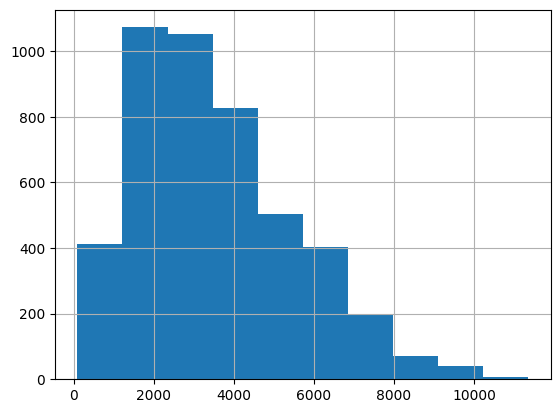

In [13]:
xy_drop_na = xy[xy['Y_rice']>=0]
xy['Y_rice'].hist()

test_xy = xy_drop_na[xy_drop_na['year']>=2019]
train_and_validation_xy = xy_drop_na[xy_drop_na['year']<2019]

train_xy = train_and_validation_xy[train_and_validation_xy['year']<2014]
val_xy = train_and_validation_xy[train_and_validation_xy['year']>=2014]

target_col = "Y_rice"
non_feature_cols = ["Y_rice"]   # keep 'year' and all area_ columns as features

feature_cols = [c for c in xy.columns if c not in non_feature_cols]
print("Number of features:", len(feature_cols))

# Features / targets for each split
X_train_df = train_xy[feature_cols].copy()
y_train_df = train_xy[[target_col]].copy()

X_val_df   = val_xy[feature_cols].copy()
y_val_df   = val_xy[[target_col]].copy()

X_test_df  = test_xy[feature_cols].copy()
y_test_df  = test_xy[[target_col]].copy()

# Scale features using StandardScaler (fit on train only)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df).astype(np.float32)
X_val_scaled   = scaler_X.transform(X_val_df).astype(np.float32)
X_test_scaled  = scaler_X.transform(X_test_df).astype(np.float32)

# Targets in original scale
y_train = y_train_df[target_col].to_numpy().astype(np.float32)
y_val   = y_val_df[target_col].to_numpy().astype(np.float32)
y_test  = y_test_df[target_col].to_numpy().astype(np.float32)

def check_arr(name, arr):
    print(f"{name}: NaN={np.isnan(arr).any()}, inf={np.isinf(arr).any()}, shape={arr.shape}")

check_arr("X_train_scaled", X_train_scaled)
check_arr("y_train",        y_train)
check_arr("X_val_scaled",   X_val_scaled)
check_arr("y_val",          y_val)
check_arr("X_test_scaled",  X_test_scaled)
check_arr("y_test",         y_test)

def clean_array(arr, name):
    arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
    print(
        f"{name}: NaN={np.isnan(arr).any()}, "
        f"inf={np.isinf(arr).any()}, "
        f"min={arr.min():.4f}, max={arr.max():.4f}"
    )
    return arr

X_train_scaled = clean_array(X_train_scaled, "X_train_scaled")
X_val_scaled   = clean_array(X_val_scaled,   "X_val_scaled")
X_test_scaled  = clean_array(X_test_scaled,  "X_test_scaled")

y_train = clean_array(y_train, "y_train")
y_val   = clean_array(y_val,   "y_val")
y_test  = clean_array(y_test,  "y_test")

In [7]:
def create_sequences(df_raw, X_scaled, y_raw, seq_len):
    """
    df_raw : pandas DataFrame (train_xy, val_xy, or test_xy)
    X_scaled : scaled features aligned with df_raw rows
    y_raw : target values aligned with df_raw rows
    seq_len : length of input sequence (number of years)

    Returns:
        X_seq : (N, seq_len, num_features)
        y_seq : (N,)
    """
    df = df_raw.copy().reset_index(drop=True)
    df = df.sort_values("year")          # order by year

    idx = df.index.to_numpy()
    X_sorted = X_scaled[idx, :]
    y_sorted = y_raw[idx]

    X_seqs = []
    y_seqs = []

    for i in range(len(df) - seq_len):
        X_seqs.append(X_sorted[i:i+seq_len, :])
        y_seqs.append(y_sorted[i+seq_len])   # next year's Y_rice

    X_seqs = np.array(X_seqs, dtype=np.float32)
    y_seqs = np.array(y_seqs, dtype=np.float32)

    print(f"Created sequences: {X_seqs.shape[0]} samples, "
          f"seq_len={seq_len}, num_features={X_seqs.shape[2] if X_seqs.size>0 else 'NA'}")
    return X_seqs, y_seqs

# Choose sequence length (years)
seq_len = 5

X_train_seq, y_train_seq = create_sequences(train_xy, X_train_scaled, y_train, seq_len)
X_val_seq,   y_val_seq   = create_sequences(val_xy,   X_val_scaled,   y_val,   seq_len)
X_test_seq,  y_test_seq  = create_sequences(test_xy,  X_test_scaled,  y_test,  seq_len)

print("Train seq shape:", X_train_seq.shape, y_train_seq.shape)
print("Val   seq shape:", X_val_seq.shape,   y_val_seq.shape)
print("Test  seq shape:", X_test_seq.shape,  y_test_seq.shape)

if X_val_seq.shape[0] == 0:
    raise ValueError("Validation sequences are empty. Decrease seq_len or check data.")

Created sequences: 3444 samples, seq_len=5, num_features=293
Created sequences: 565 samples, seq_len=5, num_features=293
Created sequences: 565 samples, seq_len=5, num_features=293
Train seq shape: (3444, 5, 293) (3444,)
Val   seq shape: (565, 5, 293) (565,)
Test  seq shape: (565, 5, 293) (565,)


In [8]:
batch_size = 64

train_dataset = TensorDataset(
    torch.from_numpy(X_train_seq),
    torch.from_numpy(y_train_seq).unsqueeze(-1)  # (N, 1)
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val_seq),
    torch.from_numpy(y_val_seq).unsqueeze(-1)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_seq),
    torch.from_numpy(y_test_seq).unsqueeze(-1)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("len(train_dataset) =", len(train_dataset))
print("len(val_dataset)   =", len(val_dataset))
print("len(test_dataset)  =", len(test_dataset))

len(train_dataset) = 3444
len(val_dataset)   = 565
len(test_dataset)  = 565


In [9]:
class YieldLSTM(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        # x: (batch, seq_len, num_features)
        out, (hn, cn) = self.lstm(x)   # hn: (num_layers, batch, hidden)
        last_hidden = hn[-1]           # (batch, hidden_size)
        out = self.fc(last_hidden)     # (batch, 1)
        return out

num_features = X_train_seq.shape[2]
hidden_size  = 64
num_layers   = 1
dropout      = 0.2
learning_rate = 1e-3
num_epochs    = 150
patience      = 10

model = YieldLSTM(num_features, hidden_size, num_layers, dropout).to(device)
criterion = nn.MSELoss()               # train in MSE
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

YieldLSTM(
  (lstm): LSTM(293, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, device="cpu"):
    best_state_dict = model.state_dict()
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses = []
    val_losses   = []

    for epoch in range(num_epochs):
        # ---------- Train ----------
        model.train()
        running_train_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)   # MSE
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_mse = running_train_loss / max(1, len(train_loader))
        train_rmse = train_mse ** 0.5

        # ---------- Validate ----------
        if len(val_loader) == 0:
            raise ValueError("Validation DataLoader is empty.")

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)   # MSE
                running_val_loss += loss.item()

        val_mse  = running_val_loss / len(val_loader)
        val_rmse = val_mse ** 0.5

        train_losses.append(train_rmse)
        val_losses.append(val_rmse)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

        # ---------- Early stopping (on val MSE) ----------
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_state_dict)
    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)


Epoch 1/150 - Train RMSE: nan, Val RMSE: nan
Epoch 2/150 - Train RMSE: nan, Val RMSE: nan
Epoch 3/150 - Train RMSE: nan, Val RMSE: nan
Epoch 4/150 - Train RMSE: nan, Val RMSE: nan
Epoch 5/150 - Train RMSE: nan, Val RMSE: nan
Epoch 6/150 - Train RMSE: nan, Val RMSE: nan
Epoch 7/150 - Train RMSE: nan, Val RMSE: nan
Epoch 8/150 - Train RMSE: nan, Val RMSE: nan
Epoch 9/150 - Train RMSE: nan, Val RMSE: nan
Epoch 10/150 - Train RMSE: nan, Val RMSE: nan
Early stopping at epoch 10


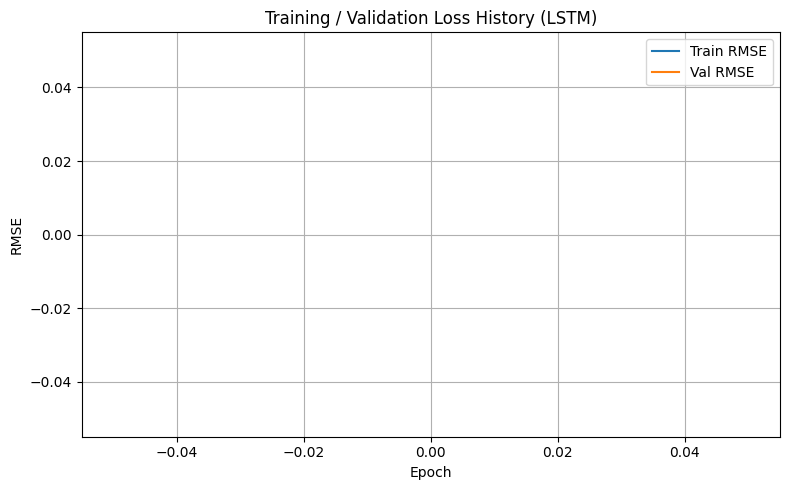

In [11]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train RMSE")
plt.plot(val_losses,   label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training / Validation Loss History (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
def predict_loader(model, data_loader, device="cpu"):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X).cpu().numpy().flatten()
            preds.extend(outputs)
            trues.extend(batch_y.numpy().flatten())
    return np.array(trues), np.array(preds)

y_train_true, y_train_pred = predict_loader(model, train_loader, device)
y_val_true,   y_val_pred   = predict_loader(model, val_loader,   device)
y_test_true,  y_test_pred  = predict_loader(model, test_loader,  device)

def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.4f}, R²: {r2:.4f}")

print_metrics("Train", y_train_true, y_train_pred)
print_metrics("Val",   y_val_true,   y_val_pred)
print_metrics("Test",  y_test_true,  y_test_pred)

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
def plot_scatter(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
    plt.xlabel("True Y_rice")
    plt.ylabel("Predicted Y_rice")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_scatter(y_val_true,  y_val_pred,  "Validation: True vs Predicted Y_rice (LSTM)")
plot_scatter(y_test_true, y_test_pred, "Test: True vs Predicted Y_rice (LSTM)")
